# Modelización del IPC para la vivienda Española con series temporales

## Introducción: Presentación de la serie a Analizar

## Desarrollo

En primer lugar cargamos las liberías y el dataset a utilizar.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tabulate import tabulate
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
import warnings


warnings.filterwarnings(
    "ignore", 
    message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters."
)
warnings.filterwarnings(
    "ignore", 
    message="Non-invertible starting MA parameters found. Using zeros as starting parameters."
)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


df = pd.read_excel("IPCVivienda.xlsx")
df

c:\Users\AMON\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Total Nacional. Vivienda en alquiler. Índice.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Serie: IPC253843,NaN,NaN,NaN,NaN,NaN,NaN
1,Periodicidad: Mensual,NaN,NaN,NaN,NaN,NaN,NaN
2,Unidad: Índice,NaN,NaN,NaN,NaN,NaN,NaN
3,Escala:,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,DATOS,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
278,NaN,2002M05,NaN,70.722,Definitivo,NaN,NaN
279,NaN,2002M04,NaN,70.475,Definitivo,NaN,NaN
280,NaN,2002M03,NaN,70.204,Definitivo,NaN,NaN
281,NaN,2002M02,NaN,69.851,Definitivo,NaN,NaN


Vemos que el dataset cargado contiene muchas columnas que no nos interesan para analizar la evolución del IPC. Procedemos a limpiar el dataset. Veánse los comentarios en el siguiente bloque de código para una explicación más detallada del proceso. El output final es el dataset de la serie temporal, ordenado según antigüedad.

In [62]:
df = df.loc[6:,["Unnamed: 1", "Unnamed: 3"]] ## 
df = df.rename(columns={"Unnamed: 1": "Fecha", "Unnamed: 3": "IPC"})
df["Fecha"] = df["Fecha"].str.replace("M", "-")
df["Fecha"] = pd.to_datetime(df["Fecha"], format = "%Y-%m")
s_ipc = df.set_index(df["Fecha"])[["IPC"]].sort_values(by = "Fecha", ascending = True)
s_cortada = s_ipc.iloc[120:]
s_cortada

,IPC
Fecha,
2012-01-01,96.408
2012-02-01,96.467
2012-03-01,96.574
2012-04-01,96.609
2012-05-01,96.563
...,...
2024-09-01,106.147
2024-10-01,106.381
2024-11-01,106.609


## 2. Representación gráfica y descomposición estacional (si tuviera comportamiento estacional)

En primer lugar mostramos la gráfica de la serie temporal. Importante destacar que cogemos los datos desde 2012 para cumplir con el requisitio del entregable de tener, aproximadamente, 150 datapoints.

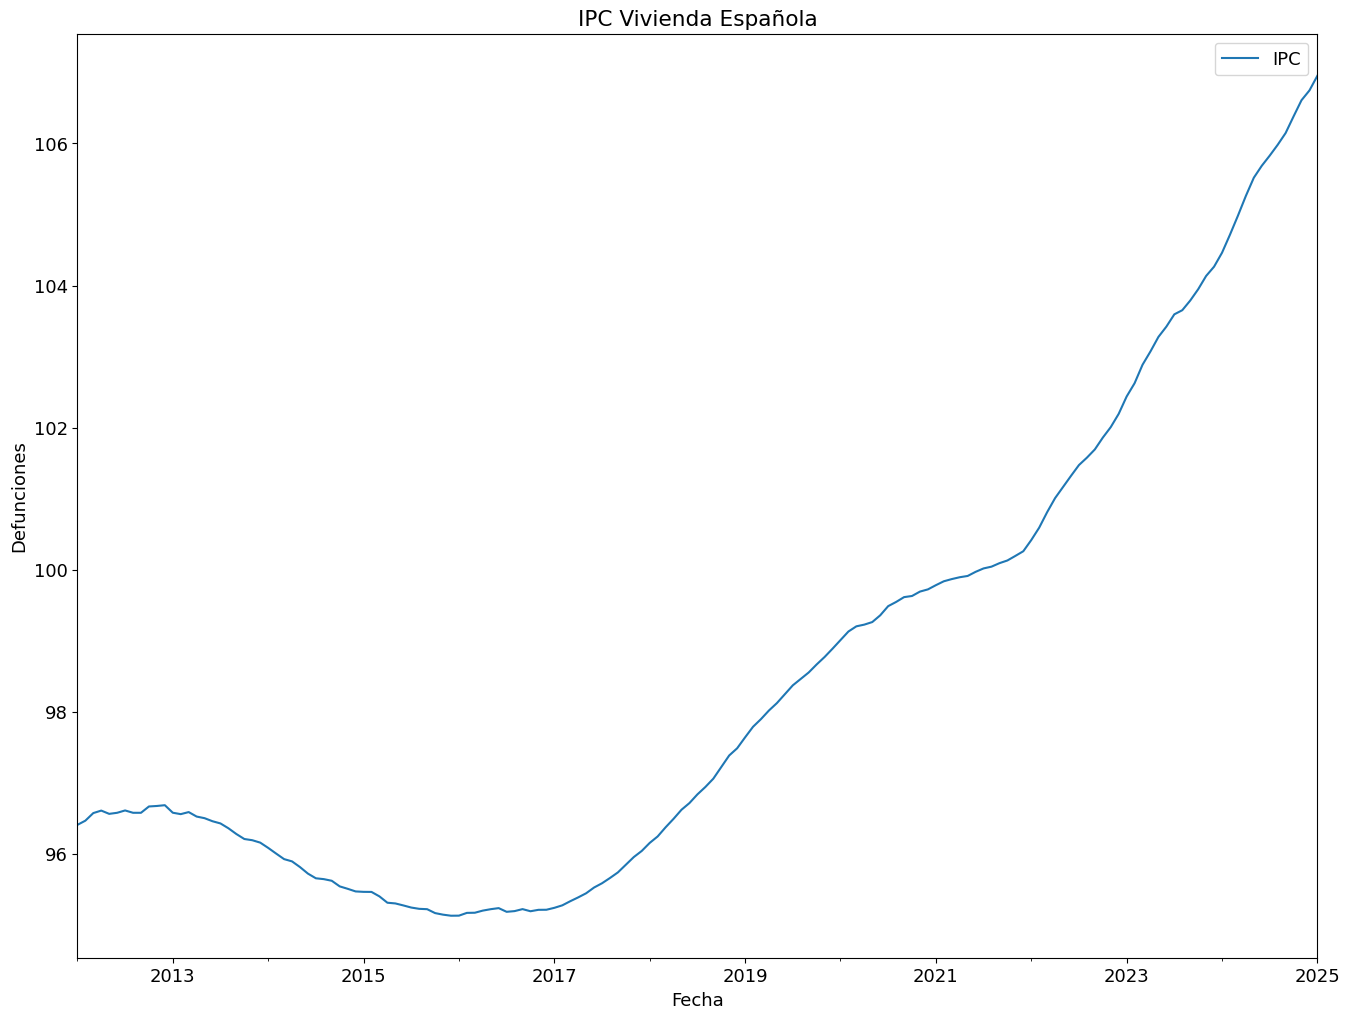

In [63]:
s_cortada.plot()
plt.title('IPC Vivienda Española')
plt.xlabel('Fecha')
plt.ylabel('Defunciones')
plt.show()

A continuación veamos la descompoisición estacional. 

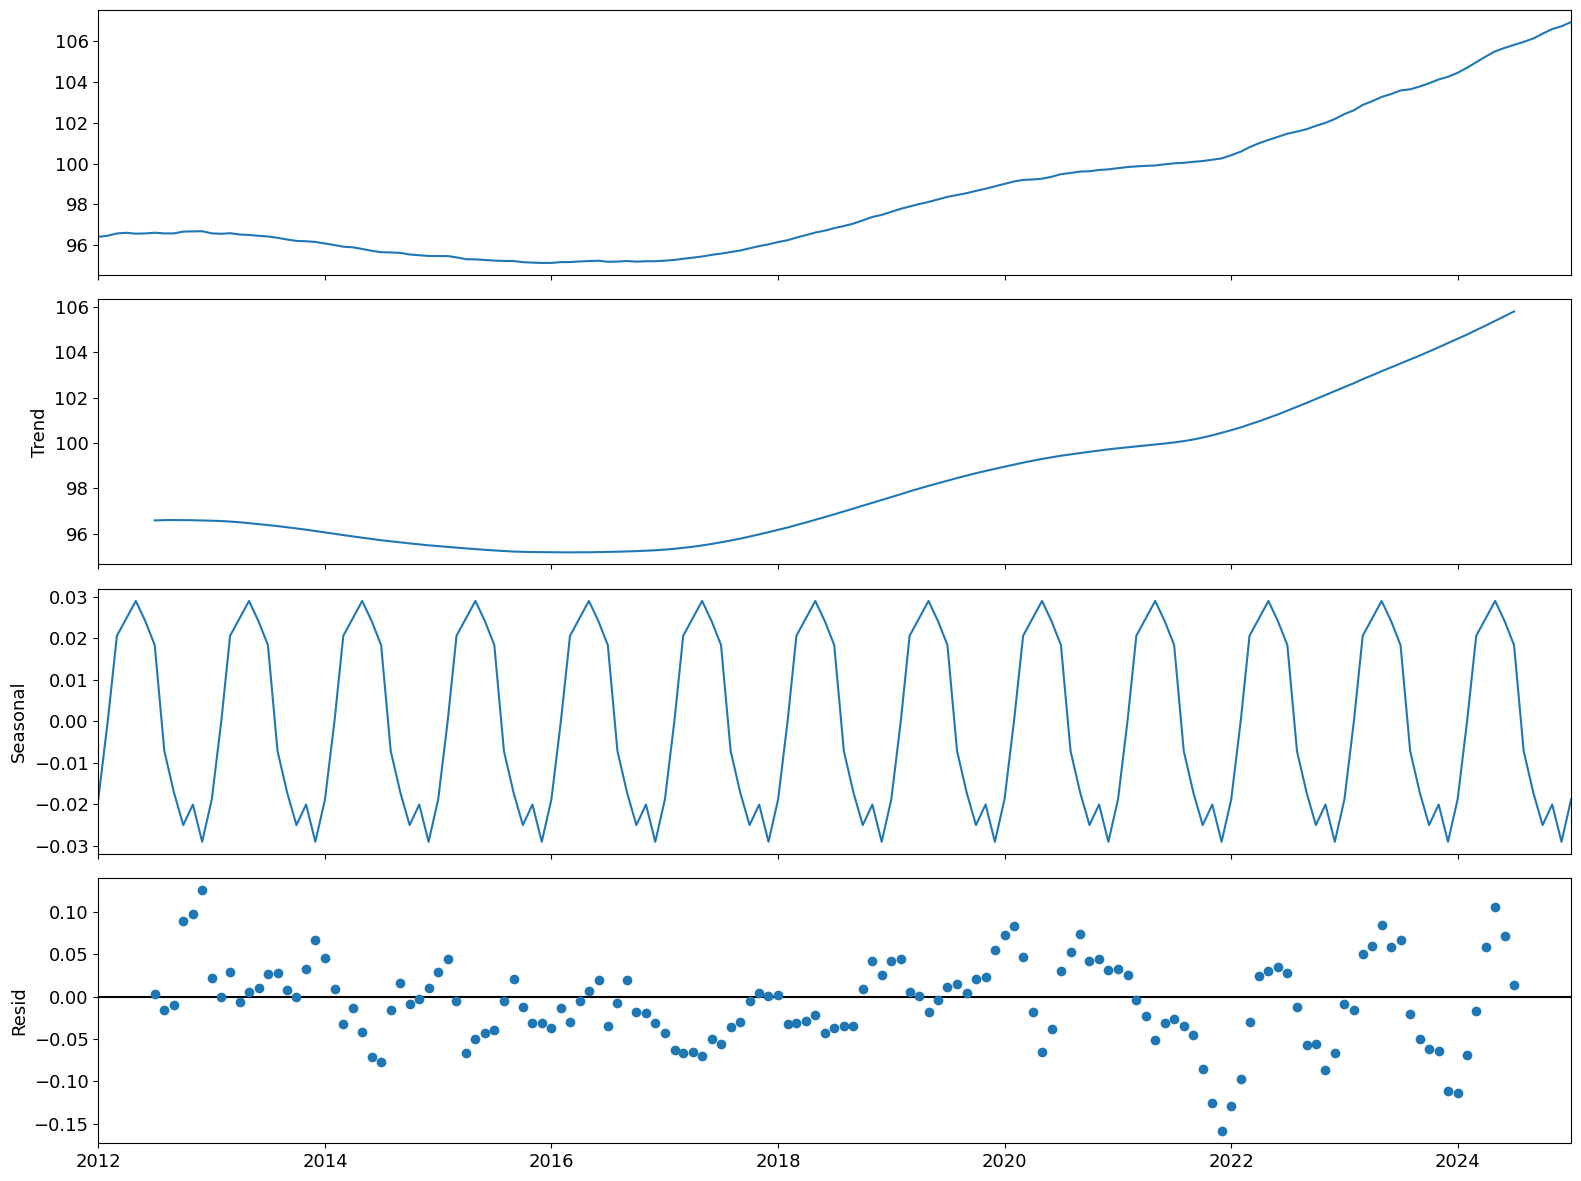

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

Addtitive_decomposition = seasonal_decompose(s_cortada, model='additive', period=12)
plt.rc("figure", figsize=(16,12))
plt.rc("font", size = 13)
fig = Addtitive_decomposition.plot()

Para la serie original, comprobamos que:
1. Se observa una tendencia creciente en los últimos años, lo que indica que el IPC ha ido aumentando con el tiempo.
2. También hay fluctuaciones regulares, lo que indica estacionalidad. 

Para la componente de tendencia:
1. Se nota una fase de ligera disminución, seguida de un periodo de crecimiento constante.
2. Esto indica que, aunque hubo una caída en algún momento, el IPC ha mostrado un aumento general en el tiempo.

Para la componente estacional:
1. Muestra patrones recurrentes de cadda período (en este caso, cada 12 meses, lo que sugiere una estacionalidad anual).
2. Se ve claramente que el IPC sigue una oscilación repetitiva, lo que podría reflejar variaciones estacionales en los precios de alquiler.

Para la componente de residuos:
1. Los residuos no parecen mostrar un patrón fuerte, sin embargo, no parece completamente aleatorio. Hay ciertos periodos en los que los valores parecen agruparse, lo que sugiere que aún hay patrones no capturados en la tendencia o estacionalidad. Podemos hace un análisis rápido de estos residuos.

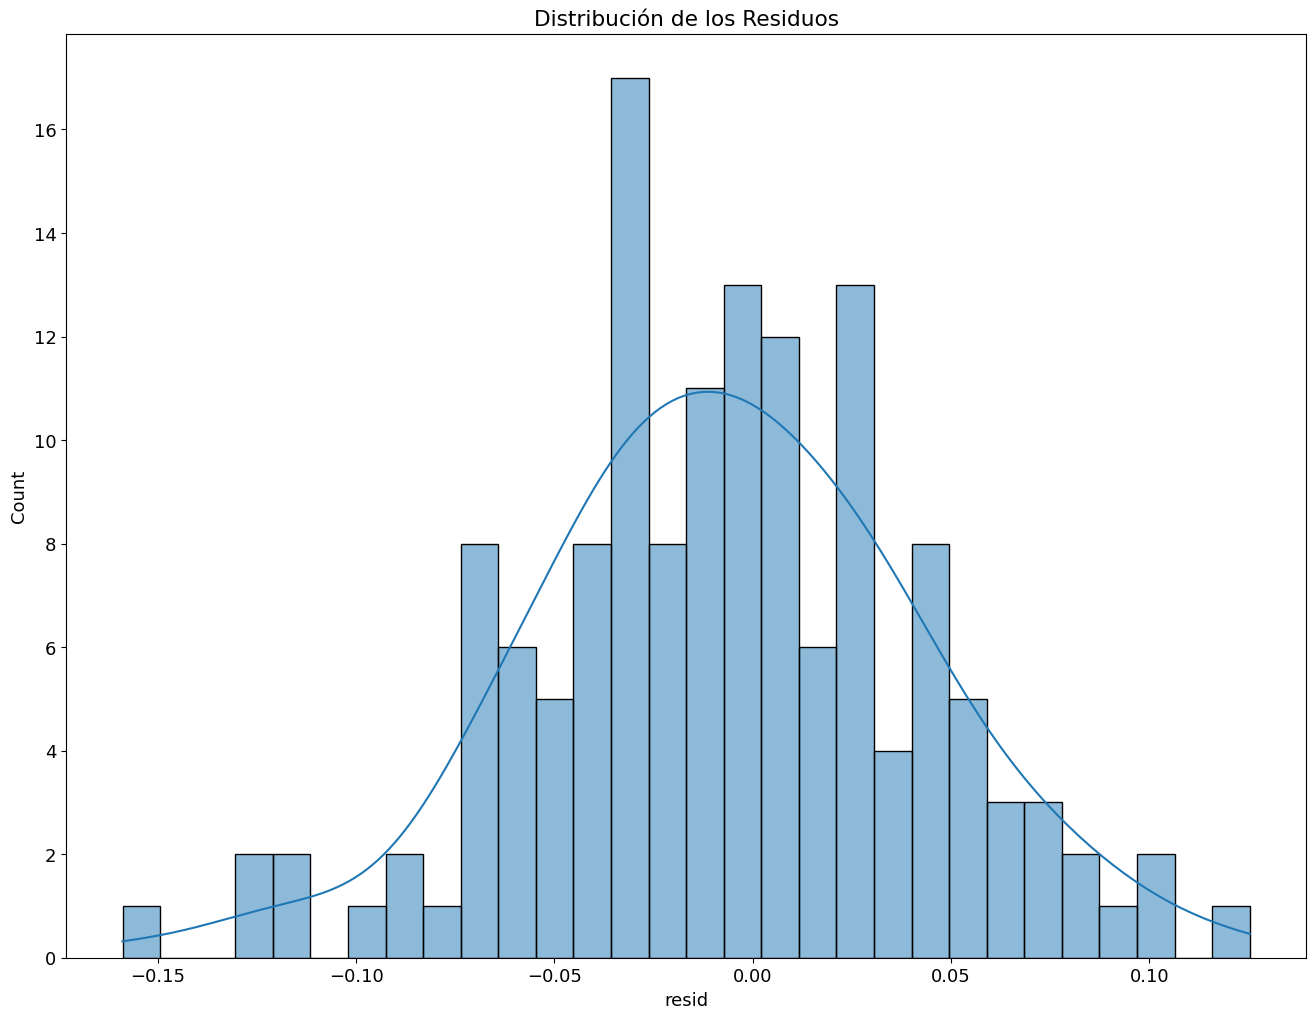

In [65]:
sns.histplot(Addtitive_decomposition.resid.dropna(), bins=30, kde=True)
plt.title("Distribución de los Residuos")
plt.show()


Los residuos parecen seguir, aproximadamente, una distribución normal. Si no fuera así, podría ser un indicio de que el modelo no ha capturado completamente la estructura de los datos.

## 3. Partición de los datos en Train y Test

In [66]:
train = s_cortada[:145]
test = s_cortada[145:]
train = train["IPC"].astype(float)
train.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 145 entries, 2012-01-01 to 2024-01-01
Series name: IPC
Non-Null Count  Dtype  
--------------  -----  
145 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


## 4. Modelos de suavizado exponenical
Encontrar el modelo de suavizado esponencial más adecuado, mostrando una tabla con los estimadores de los parámetros del modelo elegido. Para dicho modelo, representar gráficamente la serie observada y la suavizada con las predicciones para el periodo TEST. Mostrar una tabla con las predicciones (2).

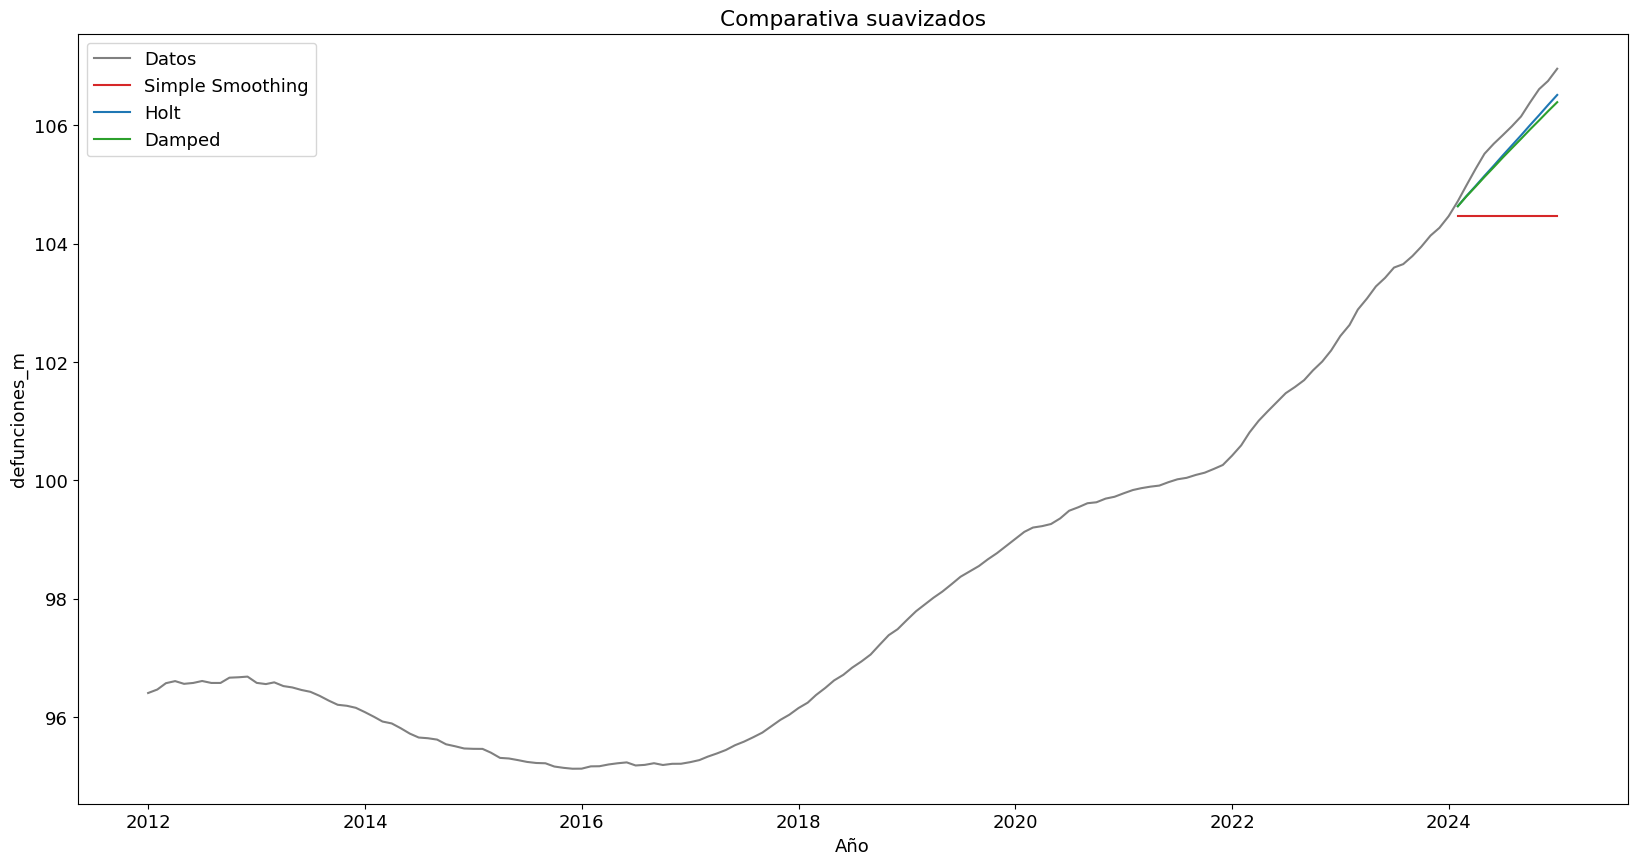

In [67]:
## Suavizado Simple
modelSimpleSmoothing = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcastSimpleSmoothing = modelSimpleSmoothing.forecast(12)

modelHolt = Holt(train, initialization_method="estimated").fit()
fcastHolt = modelHolt.forecast(12)

modelHoltDamped = Holt(train, damped_trend=True, initialization_method="estimated").fit()
fcastHoltDamped = modelHoltDamped.forecast(12)


plt.figure(figsize=(20,10))

plt.plot(s_cortada, label = 'Datos', color = 'gray')

plt.plot(fcastSimpleSmoothing, label = 'Simple Smoothing', color = 'tab:red')
plt.plot(fcastHolt, label = 'Holt', color = 'tab:blue')
plt.plot(fcastHoltDamped, label = "Damped", color = 'tab:green')
plt.xlabel('Año')
plt.ylabel('defunciones_m')
plt.title('Comparativa suavizados')
plt.legend()
plt.show()

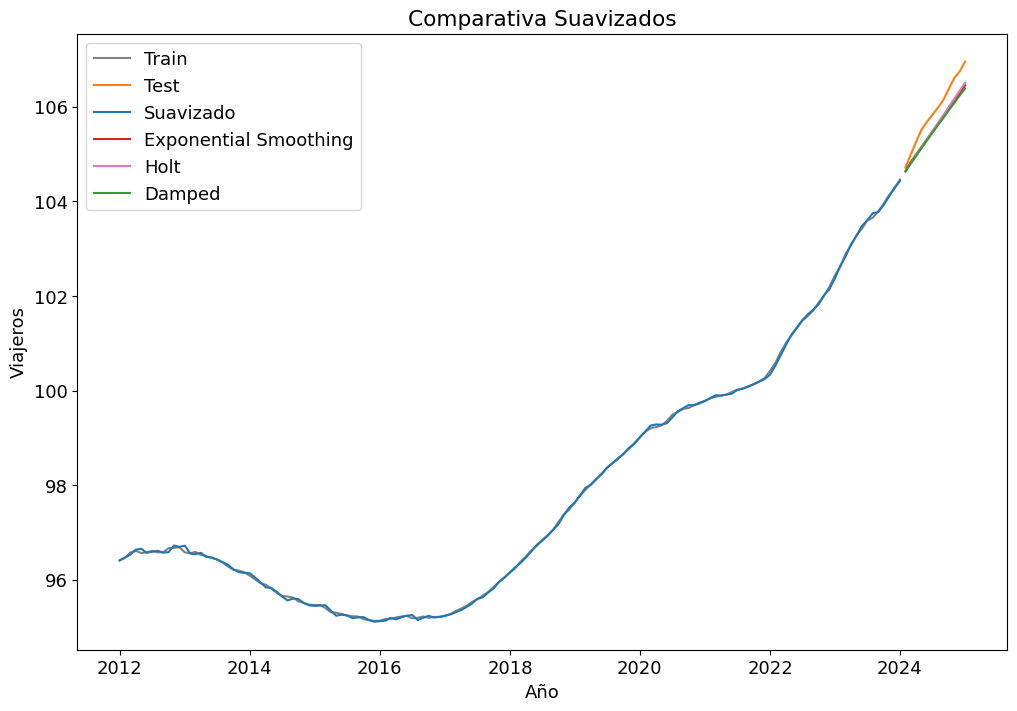

In [68]:
modelExpSmoothing = ExponentialSmoothing(train, seasonal_periods=12, trend="add",
                              seasonal = "add", initialization_method="estimated").fit()
fcastExpSmoothing = modelExpSmoothing.forecast(12)

plt.figure(figsize=(12,8))

plt.plot(train, label = 'Train', color = 'gray')
plt.plot(test, label = 'Test', color = 'tab:orange')
plt.plot(modelExpSmoothing.fittedvalues, label='Suavizado', color = 'tab:blue')
plt.plot(fcastExpSmoothing, color = 'tab:red', label = "Exponential Smoothing")
plt.plot(fcastHolt, label = 'Holt', color = 'tab:pink')
plt.plot(fcastHoltDamped, label = "Damped", color = 'tab:green')
plt.xlabel('Año')
plt.ylabel('Viajeros')
plt.title("Comparativa Suavizados")
plt.legend()
plt.show()

# Exogemos Exponential Smoothing --> Justificar

In [69]:
headers = ['Name', 'Param', 'Value', 'Optimized']
table_Holt = tabulate(modelHolt.params_formatted, headers, tablefmt='fancy_grid')
table_Damped = tabulate(modelHoltDamped.params_formatted, headers, tablefmt='fancy_grid')
tableExpSmoothing = tabulate(modelExpSmoothing.params_formatted, headers, tablefmt='fancy_grid')

In [70]:
print("Table Holt\n" + table_Holt)

Table Holt
╒═════════════════╤═════════╤════════════╤═════════════╕
│ Name            │ Param   │      Value │ Optimized   │
╞═════════════════╪═════════╪════════════╪═════════════╡
│ smoothing_level │ alpha   │  1         │ True        │
├─────────────────┼─────────┼────────────┼─────────────┤
│ smoothing_trend │ beta    │  0.472964  │ True        │
├─────────────────┼─────────┼────────────┼─────────────┤
│ initial_level   │ l.0     │ 96.3512    │ True        │
├─────────────────┼─────────┼────────────┼─────────────┤
│ initial_trend   │ b.0     │  0.0567266 │ True        │
╘═════════════════╧═════════╧════════════╧═════════════╛


In [71]:
print("Table Damped\n" + table_Damped)

Table Damped
╒═════════════════╤═════════╤════════════╤═════════════╕
│ Name            │ Param   │      Value │ Optimized   │
╞═════════════════╪═════════╪════════════╪═════════════╡
│ smoothing_level │ alpha   │  1         │ True        │
├─────────────────┼─────────┼────────────┼─────────────┤
│ smoothing_trend │ beta    │  0.482392  │ True        │
├─────────────────┼─────────┼────────────┼─────────────┤
│ initial_level   │ l.0     │ 96.3492    │ True        │
├─────────────────┼─────────┼────────────┼─────────────┤
│ initial_trend   │ b.0     │  0.0586313 │ True        │
├─────────────────┼─────────┼────────────┼─────────────┤
│ damping_trend   │ phi     │  0.991361  │ True        │
╘═════════════════╧═════════╧════════════╧═════════════╛


In [72]:
print("Table Exponential Smoothing\n" + tableExpSmoothing)

Table Exponential Smoothing
╒════════════════════╤═════════╤══════════════╤═════════════╕
│ Name               │ Param   │        Value │ Optimized   │
╞════════════════════╪═════════╪══════════════╪═════════════╡
│ smoothing_level    │ alpha   │  1           │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ smoothing_trend    │ beta    │  0.463339    │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ smoothing_seasonal │ gamma   │  1.48689e-08 │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ initial_level      │ l.0     │ 96.393       │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ initial_trend      │ b.0     │  0.0450238   │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ initial_seasons.0  │ s.0     │ -0.0298835   │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ initial_seasons.1  │ s.1     │ -0.013620

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate performance on test set
predictions = {
    "Simple Smoothing": fcastSimpleSmoothing,
    "Holt": fcastHolt,
    "Damped": fcastHoltDamped,
    "Exponential Smoothing": fcastExpSmoothing,
}

errors = {}
for model_name, forecast in predictions.items():
    mae = mean_absolute_error(test, forecast[:len(test)])
    mse = mean_squared_error(test, forecast[:len(test)])
    errors[model_name] = {"MAE": mae, "MSE": mse}

# Convert errors to a DataFrame for easy viewing
errors_df = pd.DataFrame(errors).T
print(errors_df)

                            MAE       MSE
Simple Smoothing       1.439083  2.527334
Holt                   0.329116  0.118516
Damped                 0.378870  0.161077
Exponential Smoothing  0.349339  0.137883


Comprobamos que tanto Exponential Smoothing como Holt Damped son dos modelos competitivos. Debido al componente de periodicidad que hemos descubierto ahora nos decatamos por el modelo *Exponential Smoothing*.

Volvemos a representar gráficamente el modelo escogido. 

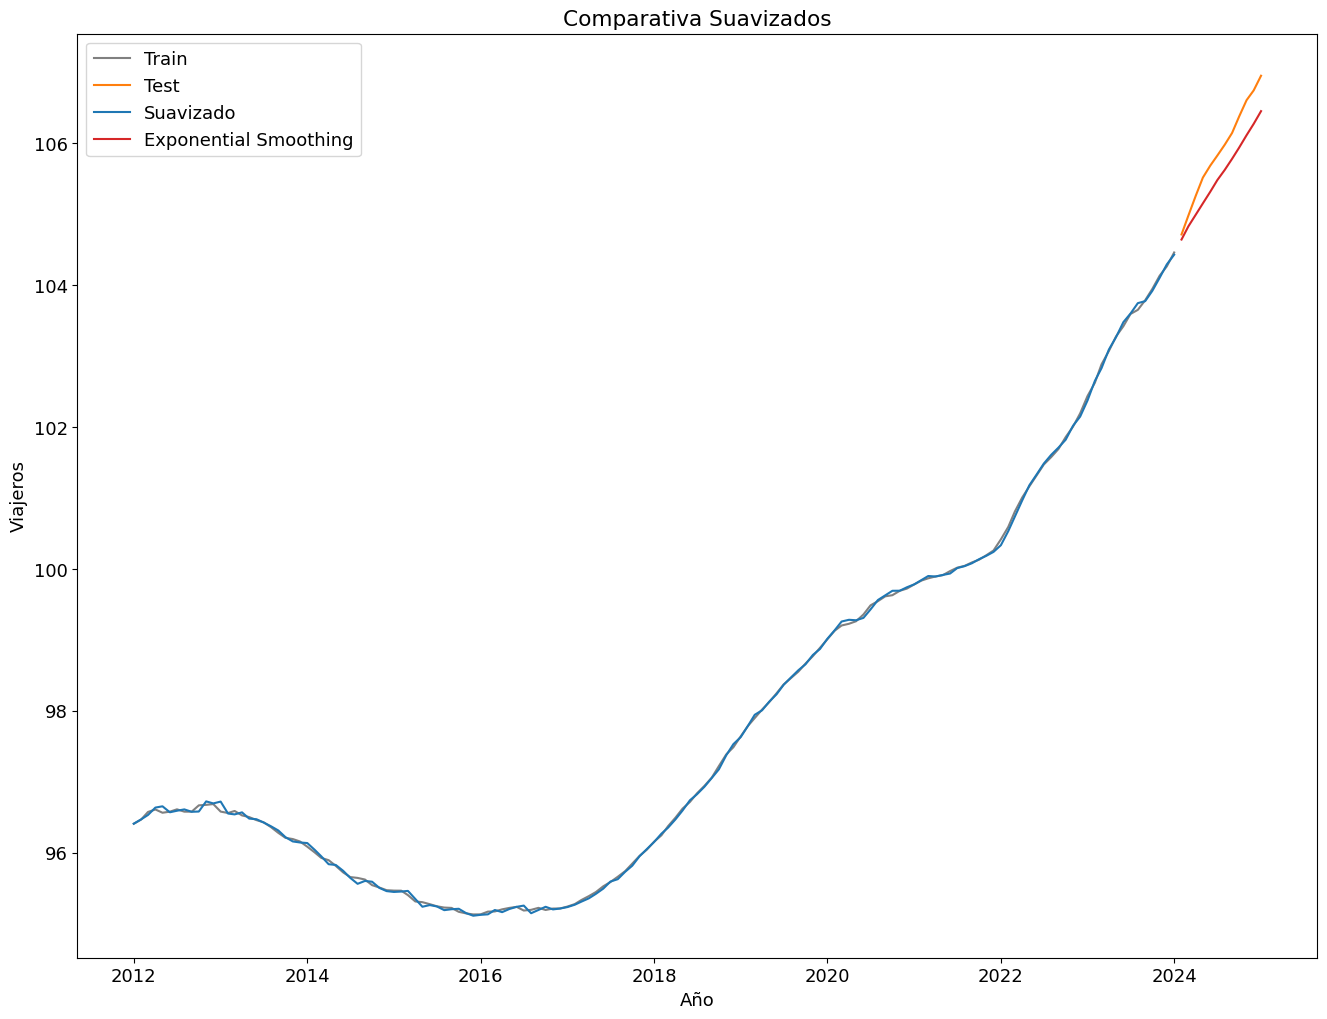

In [74]:


plt.figurefigsize=(12,8)

plt.plot(train, label = 'Train', color = 'gray')
plt.plot(test, label = 'Test', color = 'tab:orange')
plt.plot(modelExpSmoothing.fittedvalues, label='Suavizado', color = 'tab:blue')
plt.plot(fcastExpSmoothing, color = 'tab:red', label = "Exponential Smoothing")
plt.xlabel('Año')
plt.ylabel('Viajeros')
plt.title("Comparativa Suavizados")
plt.legend()
plt.show()

# Exogemos Exponential Smoothing --> Justificar

In [75]:
print("Table Exponential Smoothing\n" + tableExpSmoothing)

Table Exponential Smoothing
╒════════════════════╤═════════╤══════════════╤═════════════╕
│ Name               │ Param   │        Value │ Optimized   │
╞════════════════════╪═════════╪══════════════╪═════════════╡
│ smoothing_level    │ alpha   │  1           │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ smoothing_trend    │ beta    │  0.463339    │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ smoothing_seasonal │ gamma   │  1.48689e-08 │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ initial_level      │ l.0     │ 96.393       │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ initial_trend      │ b.0     │  0.0450238   │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ initial_seasons.0  │ s.0     │ -0.0298835   │ True        │
├────────────────────┼─────────┼──────────────┼─────────────┤
│ initial_seasons.1  │ s.1     │ -0.013620

## 5. Representar serie y los correlogramas. 

Según el resultado de los correlogramas, decidir que modelo puede ser ajustado. Ajustar el modelo adecuado comprobando que sus residuales están incorrelados (Sintaxis, tablas de los parámetros estimados y gráficos).

Nota para el lector; para la selección automática del modelo no se hace mediante la libería pmdarima, dado que no me funcionaba ni encontré forma de que lo hiciera. 

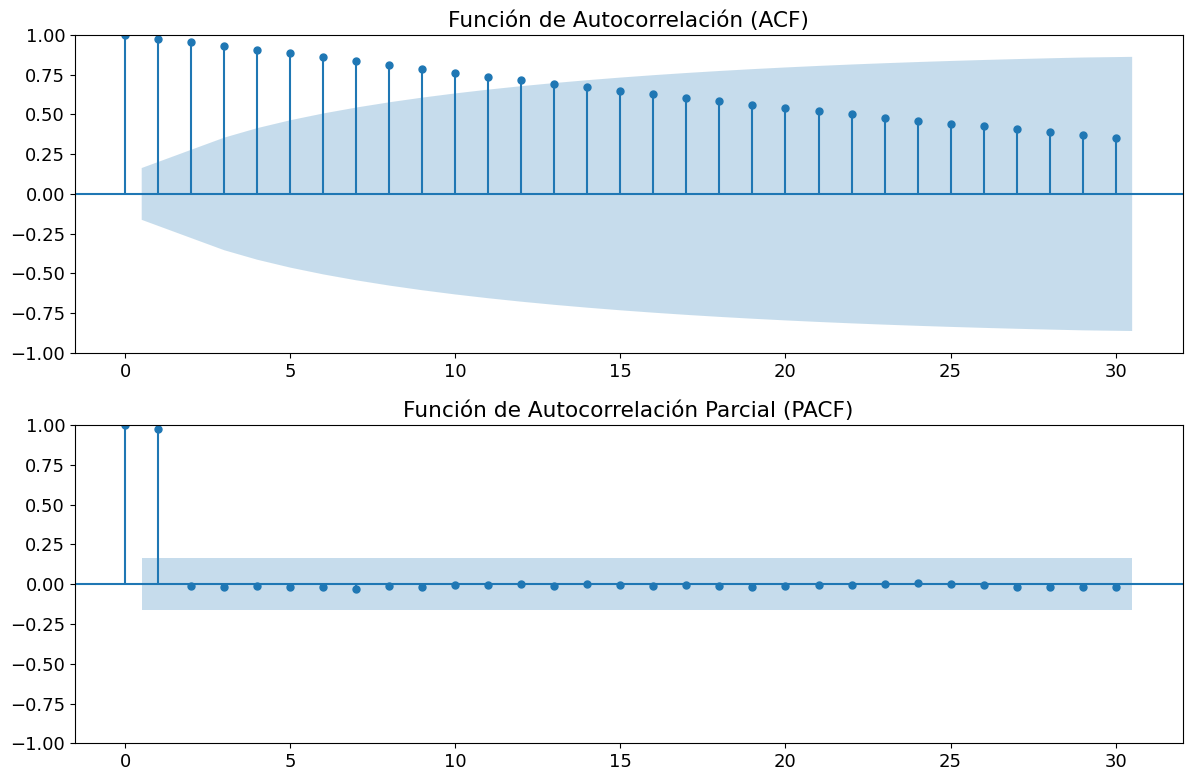

In [76]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(train, lags=30,ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF)')
plot_pacf(train, lags=30, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF)')
plt.tight_layout()
plt.show()


Como ACF decrece lentamente la serie **no** es estacionaria. Eso sugiere que la serie tiene una tendencia a largo plazo. El primer paso es entonces diferenciar la serie y luego volver a calcular la ACF y PACF para identificar los valores correctos de $p$ y $q$.

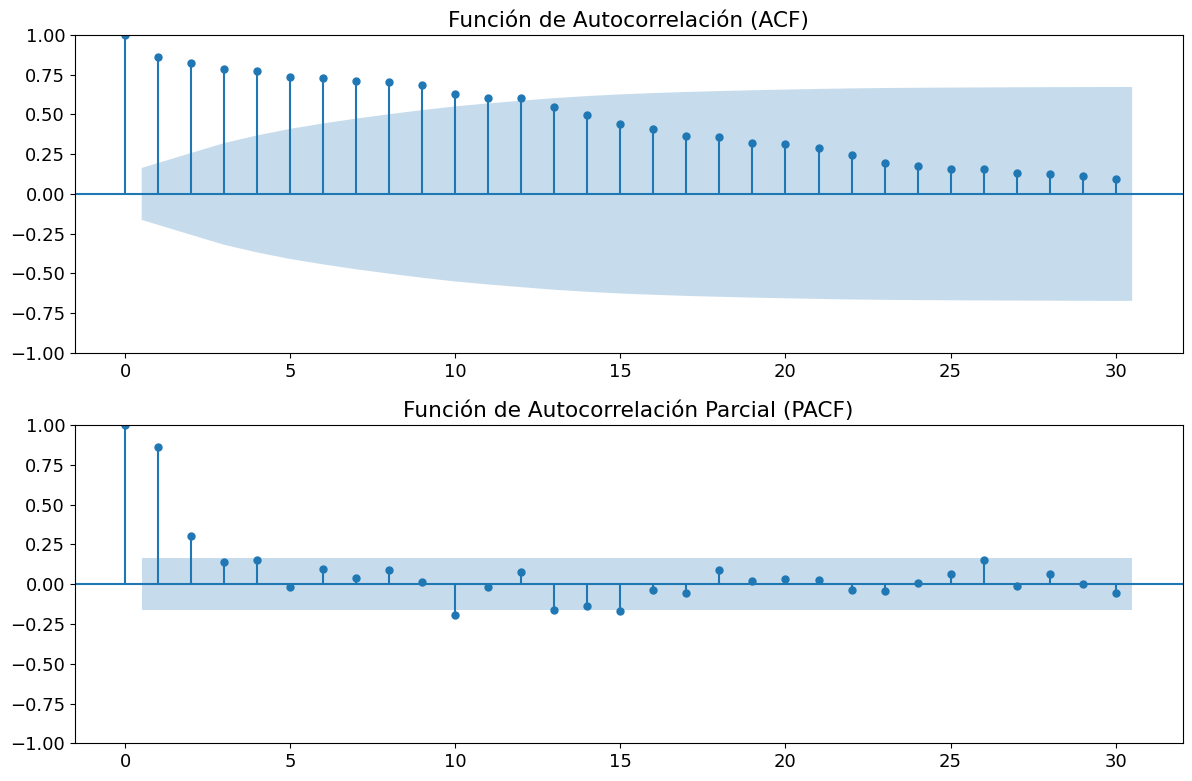

In [77]:
serie_train_dif = train.diff().dropna()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(serie_train_dif, lags=30,ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF)')
plot_pacf(serie_train_dif, lags=30, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF)')
plt.tight_layout()
plt.show()

ACF sigue decreciendo de una forma regular, por lo que volvemos a diferenciar la serie. 

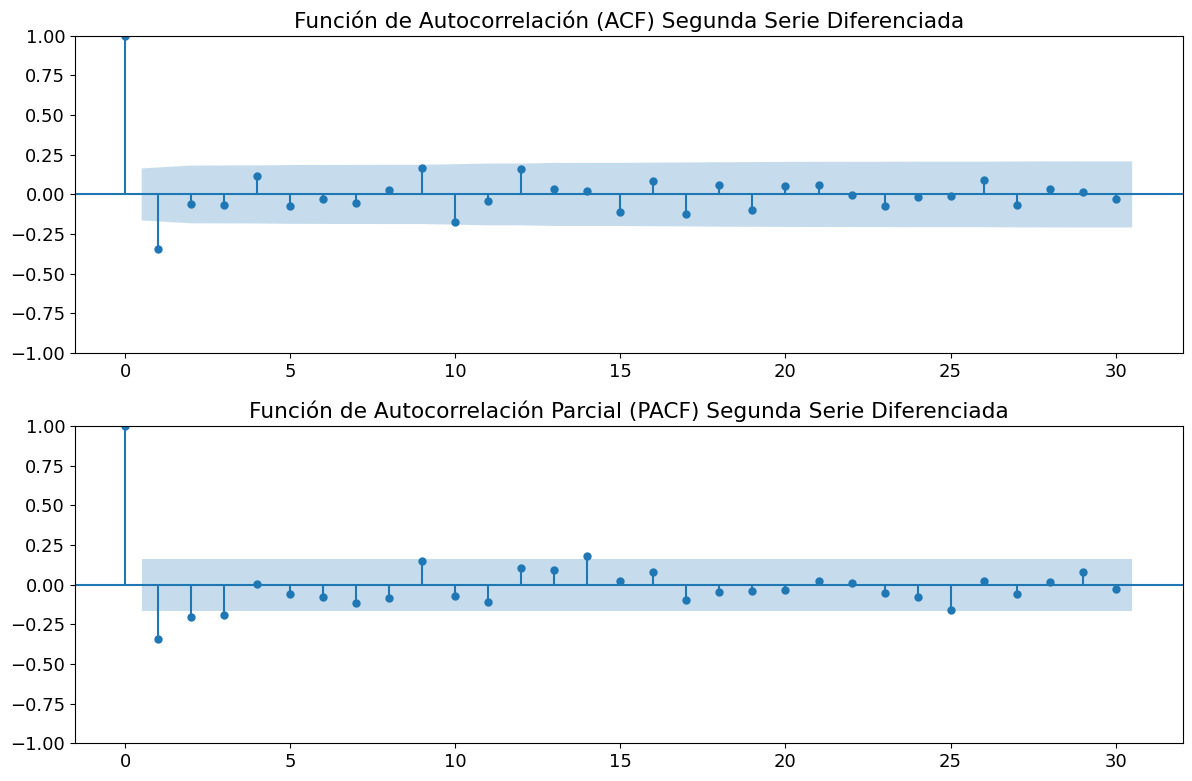

In [78]:
serie_train_dif_2 = serie_train_dif.diff().dropna()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(serie_train_dif_2, lags=30,ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF) Segunda Serie Diferenciada')
plot_pacf(serie_train_dif_2, lags=30, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF) Segunda Serie Diferenciada')
plt.tight_layout()
plt.show()

**Interpretación del nuevo modelo gráfico**
1. ACF (Autocorrelación)
    - Se corta abruptamente después de lag 1.
    - Indica que la parte MA(q) del modelo debería tener $q=1$
2. PACF (Autocorrelación Parcial)
    - Se corta en lag 3.
    - Indica que la parte AR(q) del modelo debería tener $p=3$

El Modelo ARIMA sugerido, ya que apiclamos dos diferenciaciones es ARIMA(3,2,1).

                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                  145
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 267.459
Date:                Fri, 07 Mar 2025   AIC                           -524.918
Time:                        14:07:20   BIC                           -510.104
Sample:                    01-01-2012   HQIC                          -518.898
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1851      0.520     -0.356      0.722      -1.204       0.834
ar.L2         -0.1690      0.255     -0.662      0.508      -0.669       0.331
ar.L3         -0.1338      0.177     -0.757      0.4

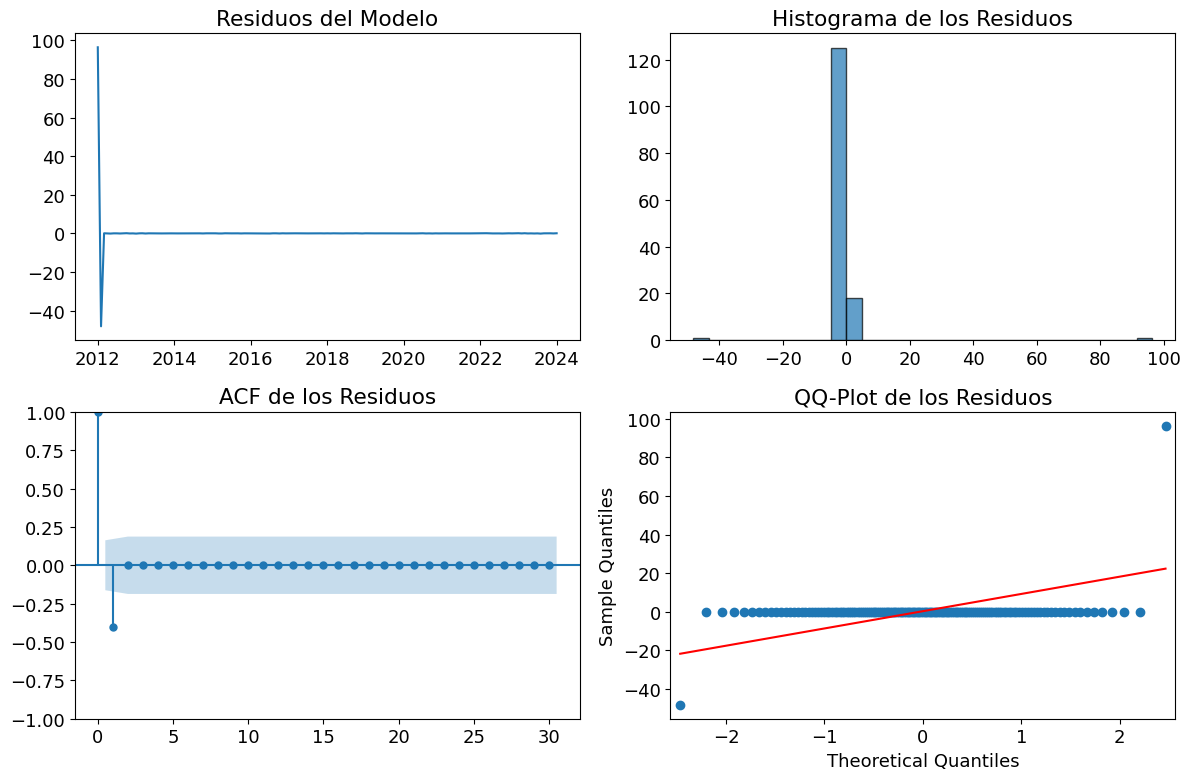

Prueba de Ljung-Box para Autocorrelación de los Residuos:
      lb_stat  lb_pvalue
10  23.575358   0.008811


In [79]:
p, d, q = 3, 2, 1
modelo = ARIMA(train, order=(p, d, q))
resultado = modelo.fit()

# Mostramos el resumen del modelo con los coeficientes estimados
print(resultado.summary())

# Graficamos los residuos
residuales = resultado.resid

fig, ax = plt.subplots(2,2, figsize=(12,8))

# Residuales a lo largo del tiempo
ax[0,0].plot(residuales)
ax[0,0].set_title("Residuos del Modelo")

# Histograma de los residuos
ax[0,1].hist(residuales, bins=30, edgecolor='k', alpha=0.7)
ax[0,1].set_title("Histograma de los Residuos")

# ACF de los residuos
sm.graphics.tsa.plot_acf(residuales, lags=30, ax=ax[1,0])
ax[1,0].set_title("ACF de los Residuos")

# QQ-Plot de los residuos
sm.qqplot(residuales, line='s', ax=ax[1,1])
ax[1,1].set_title("QQ-Plot de los Residuos")

plt.tight_layout()
plt.show()

# Prueba de Ljung-Box para verificar independencia de los residuos
ljung_box_test = acorr_ljungbox(residuales, lags=[10], return_df=True)
print("Prueba de Ljung-Box para Autocorrelación de los Residuos:")
print(ljung_box_test)

El modeo ARIMA(3,2,1) no parece óptimo porque:
- Los coeficientes no son significativos.
- Los residuos tienen estructura y no siguen una distribución normal.
- Se observa un problema en los residuos al inicio de la serie. 

Podemos plantear varias alternativas para mejorarlo, podemos probar con otros modelos ARIMA.

In [80]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# Definir los rangos de los parámetros ARIMA (p, d, q)
p_values = range(0, 4)  # Prueba de 0 a 3 en AR
d_values = range(1, 3)  # Diferenciaciones 1 o 2
q_values = range(0, 4)  # Prueba de 0 a 3 en MA

# Generar todas las combinaciones posibles de (p, d, q)
param_grid = list(itertools.product(p_values, d_values, q_values))

# DataFrame para almacenar los resultados
results = []

for param in param_grid:
    try:
        model = ARIMA(train, order=param)
        result = model.fit()
        results.append([param, result.aic, result.bic])
    except:
        continue  # En caso de error, saltar el modelo


Mejor modelo ARIMA según AIC:
Modelo (p,d,q)     (1, 1, 1)
AIC              -529.886262
BIC              -520.976822
Name: 9, dtype: object
                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                  145
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 267.943
Date:                Fri, 07 Mar 2025   AIC                           -529.886
Time:                        14:07:25   BIC                           -520.977
Sample:                    01-01-2012   HQIC                          -526.266
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9855      0.016     61.816      0.000       0.954   

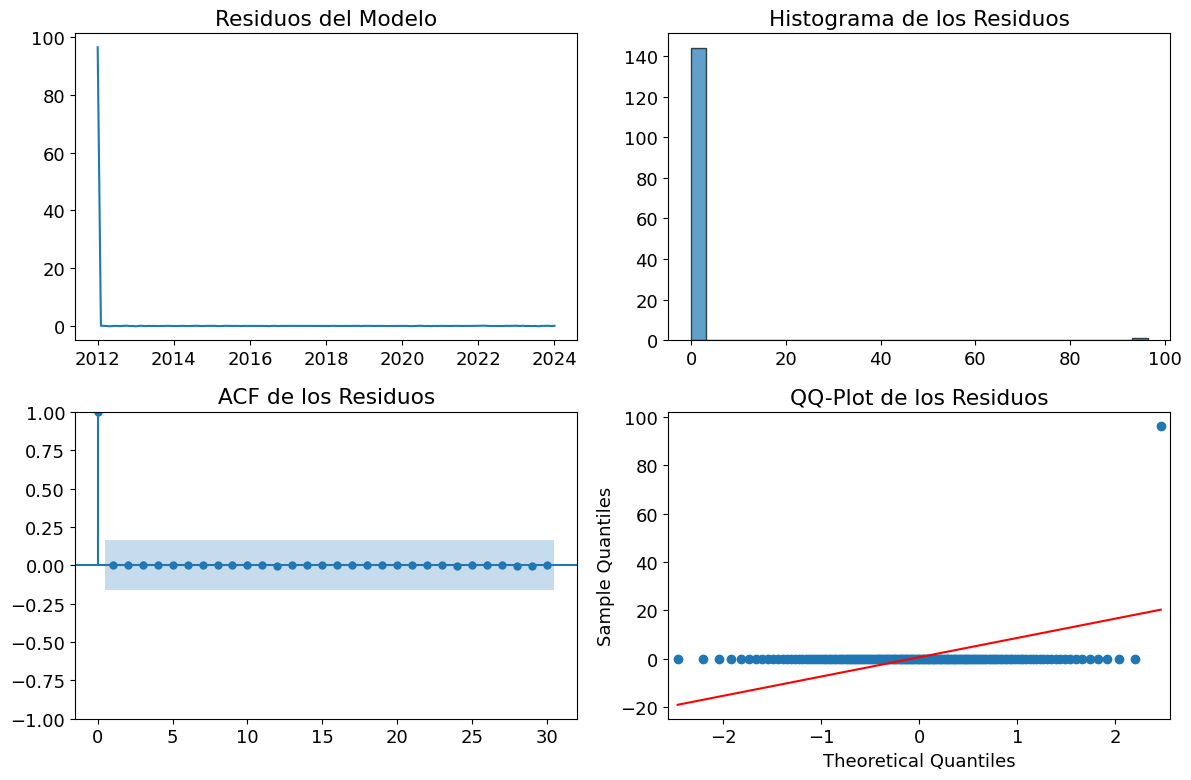

Prueba de Ljung-Box para Autocorrelación de los Residuos:
     lb_stat  lb_pvalue
10  0.000721        1.0


In [81]:
# Convertir resultados a DataFrame
results_df = pd.DataFrame(results, columns=['Modelo (p,d,q)', 'AIC', 'BIC'])

# Ordenar por AIC para encontrar el mejor modelo
best_model = results_df.sort_values(by='AIC').iloc[0]
print("\nMejor modelo ARIMA según AIC:")
print(best_model)

# Ajustar el mejor modelo
p, d, q = best_model['Modelo (p,d,q)']
final_model = ARIMA(train, order=(p, d, q))
final_result = final_model.fit()

# Mostrar resumen del modelo
print(final_result.summary())

# Graficar residuos del mejor modelo
residuales = final_result.resid

fig, ax = plt.subplots(2,2, figsize=(12,8))

# Residuales en el tiempo
ax[0,0].plot(residuales)
ax[0,0].set_title("Residuos del Modelo")

# Histograma de los residuos
ax[0,1].hist(residuales, bins=30, edgecolor='k', alpha=0.7)
ax[0,1].set_title("Histograma de los Residuos")

# ACF de los residuos
sm.graphics.tsa.plot_acf(residuales, lags=30, ax=ax[1,0])
ax[1,0].set_title("ACF de los Residuos")

# QQ-Plot de los residuos
sm.qqplot(residuales, line='s', ax=ax[1,1])
ax[1,1].set_title("QQ-Plot de los Residuos")

plt.tight_layout()
plt.show()

# Prueba de Ljung-Box para verificar independencia de los residuos
ljung_box_test = acorr_ljungbox(residuales, lags=[10], return_df=True)
print("Prueba de Ljung-Box para Autocorrelación de los Residuos:")
print(ljung_box_test)


**Evaluación del Modelo**

El mejor modelo según el AIC (-529.89) y BIC (-520.97) es ARIMA(1,1,1).

- Coeficientes AR(1) y MA(1): Ambos son estadísticamente significatios (p-valores < 0.05), lo que indica que estos términos son relevantes para el modelo.
- sigma^2 = 0.0014: Indica que la varianza del error es baja.
- Ljung-Box Test (Q-stat): $p = 0.56$ p=0.56, lo que sugiere que no hay autocorrelación significativa en los residuos.
- Jarque - Bera Test: p = 0.01, lo que indica que los residuos **no** siguen una distribución normal. 
- Kurtosis = 4.00: sugiere colas más esperadas de lo esperado en una normal. 

El modelo ARIMA(1,1,1) es adecuada en términos de autocorrelación, pero los residuos no son completamente normales. Esto sugiere que el modelo puede ser aceptable si la normalidad de los residuos no es crítica. Nos queda aún la opción de probar con un modelo SARIMA con estacionalidad de 12 meses. Usaremos la configuración 
$$\text{SARIMA}(p,d,q)(P,D,Q,s)$$
Donde 
- $s = 12$ porque la serie tiene estacionalidad anual (12 meses).
- $D$ es el número de diferenciaciones estacionales.
- $P,Q$ son los términos estacionales de AR y MA.

In [ ]:
import itertools
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

# Definir los rangos de los parámetros SARIMA (p,d,q) x (P,D,Q,s)
p_values = range(0, 3)  # No estacional AR
d_values = range(1, 3)  # Diferenciación no estacional
q_values = range(0, 3)  # No estacional MA

P_values = range(0, 3)  # Estacional AR
D_values = range(0, 2)  # Diferenciación estacional
Q_values = range(0, 3)  # Estacional MA

s = 12  # Estacionalidad anual (12 meses)

# Crear combinaciones de parámetros
param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))
best_aic = np.inf
best_model = None
best_order = None

# Variable para almacenar los resultados
results = []

# Cargar la serie temporal (debe estar previamente definida como `serie_train`)
try:
    for param in param_grid:
        order = (param[0], param[1], param[2])
        seasonal_order = (param[3], param[4], param[5], s)
        
        try:
            model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            result = model.fit()
            
            results.append([order, seasonal_order, result.aic])
            
            # Verificar si es el mejor modelo
            if result.aic < best_aic:
                best_aic = result.aic
                best_model = result
                best_order = (order, seasonal_order)
                
        except:
            continue  # En caso de error, seguir con la siguiente combinación

    # Convertir resultados a DataFrame y ordenar por AIC
    results_df = pd.DataFrame(results, columns=['Order', 'Seasonal Order', 'AIC'])
    results_df = results_df.sort_values(by='AIC')

    # Ajustar el mejor modelo encontrado
    final_model = best_model
    final_order, final_seasonal_order = best_order

    # Mostrar información del mejor modelo
    print("\nMejor modelo SARIMA encontrado:")
    print(f"Order: {final_order}, Seasonal Order: {final_seasonal_order}, AIC: {best_aic}")

    # Mostrar el resumen del modelo
    print(final_model.summary())

    # Análisis de residuos
    residuales = final_model.resid

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Residuos en el tiempo
    ax[0, 0].plot(residuales)
    ax[0, 0].set_title("Residuos del Modelo")

    # Histograma de los residuos
    ax[0, 1].hist(residuales, bins=30, edgecolor='k', alpha=0.7)
    ax[0, 1].set_title("Histograma de los Residuos")

    # ACF de los residuos
    sm.graphics.tsa.plot_acf(residuales, lags=30, ax=ax[1, 0])
    ax[1, 0].set_title("ACF de los Residuos")

    # QQ-Plot de los residuos
    sm.qqplot(residuales, line='s', ax=ax[1, 1])
    ax[1, 1].set_title("QQ-Plot de los Residuos")

    plt.tight_layout()
    plt.show()

    # Prueba de Ljung-Box para verificar independencia de los residuos
    ljung_box_test = acorr_ljungbox(residuales, lags=[10], return_df=True)
    print("Prueba de Ljung-Box para Autocorrelación de los Residuos:")
    print(ljung_box_test)

except Exception as e:
    print("Error en la ejecución del modelo SARIMA:", e)


**Evaluación del Modelo**
Orden No Estacional: (0,2,2)
- $p=0$: No hay términos autoregresivos.
- $d=2$: Se aplicaron dos diferenciaciones.
- $q=2$: Se incluyen dos términos MA para modelar la parte de medias móviles.
Orden estacional: (0,0,0,12)
- Sin términos estacionales, lo que indica que no se detectó una fuerte estacionalidad.

**Parámetros del modelo**
- MA(1) = -0.4893, significativo.
- MA(2) = -0.0749, no es significativo.
- sigma^2 = 0.0013, infica baja varianza en los errores.

**Métrica del Modelo**
- AIC = -525, indica buen ajuste.
- BIC = -6616.97 -> Más alto que AIC, pero consistente.

**Análisis de los Residuos**
- Ljung-Box Test: No hay autocorrelación en los residuos.
- Jarque-Bera Test: Los residuos no son normales, puede afectar a la precisión de los intervalos de confianza.
- Kurtosis = 4.18, indica colas más pesadas de lo esperado en una distribución normal. 

El modelo se podría mejorar probando SARIMA(0,2,1)(0,0,0,12), eliminando así el término MA(2) no significativo. 

                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                  145
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 263.707
Date:                Fri, 07 Mar 2025   AIC                           -523.414
Time:                        14:06:46   BIC                           -517.516
Sample:                    01-01-2012   HQIC                          -521.017
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5132      0.075     -6.836      0.000      -0.660      -0.366
sigma2         0.0014      0.000      9.695      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.11   Jarque-

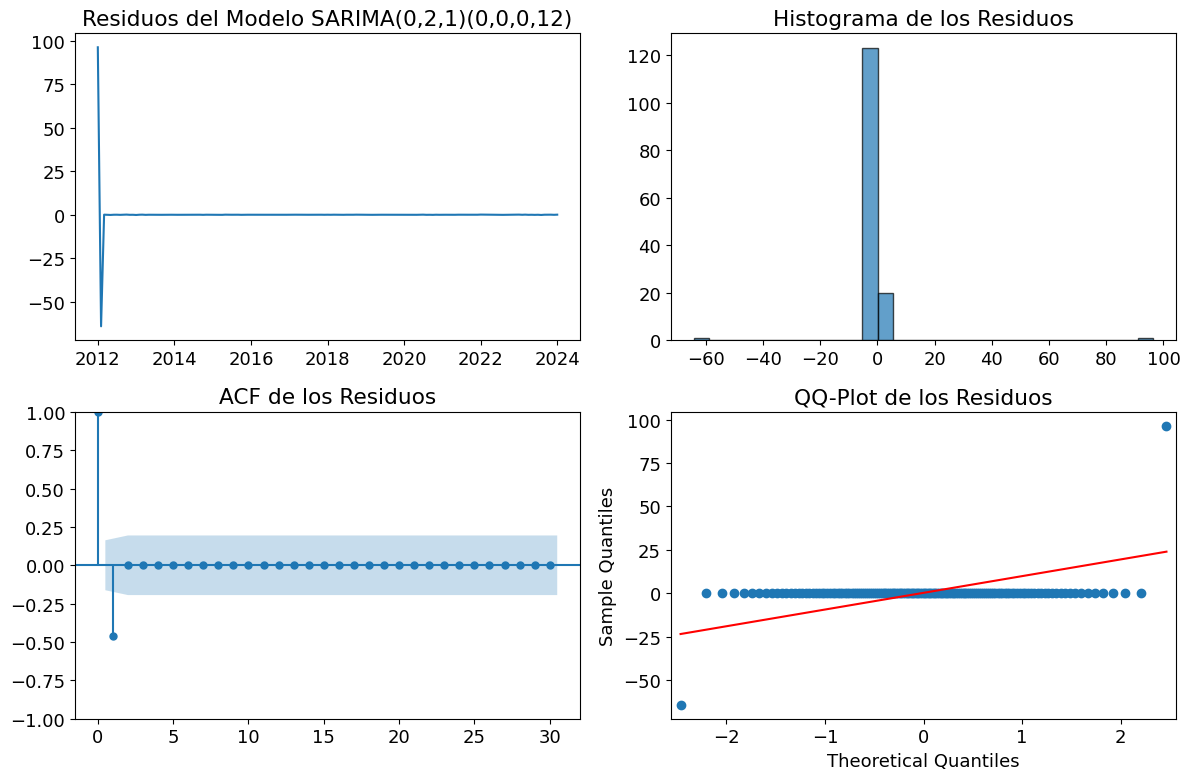

Prueba de Ljung-Box para Autocorrelación de los Residuos:
      lb_stat  lb_pvalue
10  31.428275   0.000498


In [ ]:
# Ajustar el modelo SARIMA(0,2,1)(0,0,0,12)
try:
    sarima_model = sm.tsa.SARIMAX(
        train, 
        order=(0, 2, 1), 
        seasonal_order=(0, 0, 0, 12),
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    sarima_result = sarima_model.fit()

    # Mostrar el resumen del modelo
    print(sarima_result.summary())

    # Análisis de residuos
    residuales = sarima_result.resid

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Residuos en el tiempo
    ax[0, 0].plot(residuales)
    ax[0, 0].set_title("Residuos del Modelo SARIMA(0,2,1)(0,0,0,12)")

    # Histograma de los residuos
    ax[0, 1].hist(residuales, bins=30, edgecolor='k', alpha=0.7)
    ax[0, 1].set_title("Histograma de los Residuos")

    # ACF de los residuos
    sm.graphics.tsa.plot_acf(residuales, lags=30, ax=ax[1, 0])
    ax[1, 0].set_title("ACF de los Residuos")

    # QQ-Plot de los residuos
    sm.qqplot(residuales, line='s', ax=ax[1, 1])
    ax[1, 1].set_title("QQ-Plot de los Residuos")

    plt.tight_layout()
    plt.show()

    # Prueba de Ljung-Box para verificar independencia de los residuos
    ljung_box_test = acorr_ljungbox(residuales, lags=[10], return_df=True)
    print("Prueba de Ljung-Box para Autocorrelación de los Residuos:")
    print(ljung_box_test)

except Exception as e:
    print("Error en la ejecución del modelo SARIMA(0,2,1)(0,0,0,12):", e)


En comparación al modelo anterior vemos que el AIV es similar, por lo que la reducción de complejidad no afectó significativamente el ajuste. Además, no hay autocorrelación en los residuos, lo que indica un buen ajuste. 

Sin embargo, no hay estructura estacional detectada, lo que significada que el modelo no captura patrones cíclicos en la serie. 

El modelo ARIMA(1,1,1) es mejor, debido a que tiene mejor AIC y BIC y no pierde la capacidad predictiva, a pesar de ser más simple.

In [ ]:
train

Fecha
2012-01-01     96.408
2012-02-01     96.467
2012-03-01     96.574
2012-04-01     96.609
2012-05-01     96.563
               ...   
2023-09-01    103.789
2023-10-01    103.948
2023-11-01    104.135
2023-12-01    104.266
2024-01-01    104.462
Name: IPC, Length: 145, dtype: float64

## Escribir la expresión algebraica del modelo ajustado con los parámetros estimados. 

Veamos ahora un resumen del modelo.

In [ ]:
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()

# Mostrar el resumen del modelo ajustado
arima_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    IPC   No. Observations:                  145
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 267.943
Date:                Fri, 07 Mar 2025   AIC                           -529.886
Time:                        14:06:47   BIC                           -520.977
Sample:                    01-01-2012   HQIC                          -526.266
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9855      0.016     61.816      0.000       0.954       1.017
ma.L1         -0.5071      0.082     -6.211      0.000      -0.667      -0.347
sigma2         0.0014      0.000      9.340      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                10.12
Prob(Q):                              0.56   Prob(JB):                         0.01
Heteroskedasticity (H):               1.08   Skew:                            -0.42
Prob(H) (two-sided):                  0.78   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El modelo ARIMA(1,1,1) ajustado tiene la siguiente expresión algebraica basada en los parámetros estimados:

$$(1-0.9855L)(1-L)Y_t=(1+0.50701)\varepsilon_t$$

- L es el operador de rezago = $LY_t = Y_{t-1}$
- (1-L)Y_t representa la deiferenciación de primer orden que transforme la serie en estacionaria.
- 0.9855 es el coeficiente del término autorregresivo.
- 0.70701 es el coeficiente de término me media móvil.
- $\varepsilon$ representa el término de error. 

Aplicando la diferencia queda:

$$Y_t-Y_{t-1}-0.9855Y_{t-1}+0.9855Y_{t-2}=\varepsilon-0.5071\varepsilon_{t-1}$$

## Calculas las predicciones y los intervalos de confianza.

Calculas las predicciones y los intervalos de confianza para las unidades de tiempo que se considere oportuno, dependiendo de la serie, siguientes al último valor observado. Representarlas gráficamente.

In [ ]:
forecast_obj = arima_fit.get_forecast(steps=12)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

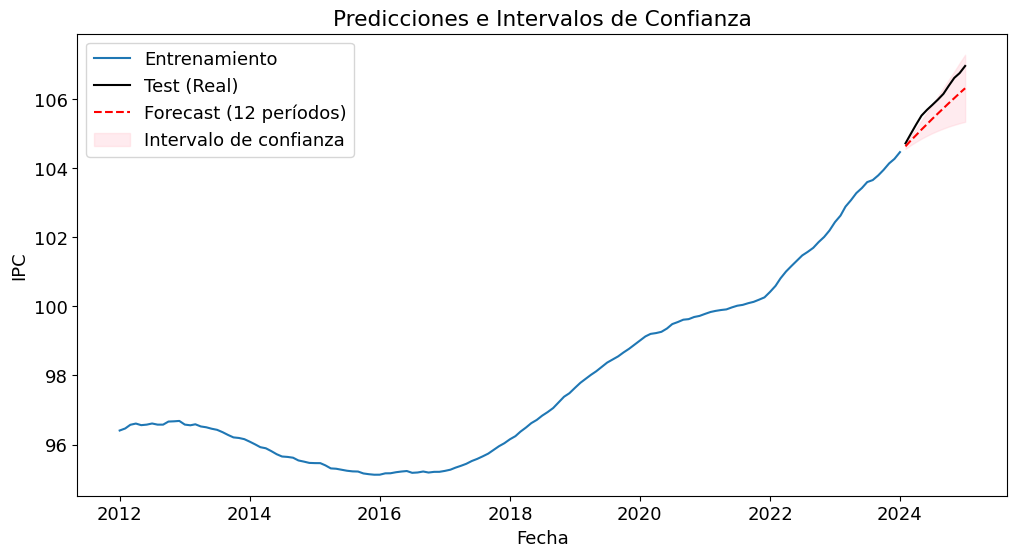

In [ ]:
# 2. Predicción para el período de test (utilizando los datos ya observados)
# Se predice desde el primer índice de test hasta el último
pred_test = arima_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Generar el gráfico con los datos reales y las predicciones
plt.figure(figsize=(12,6))

# Datos de entrenamiento
plt.plot(train.index, train, label='Entrenamiento')

# Datos reales de test
plt.plot(test.index, test, label='Test (Real)', color='black')

# Forecast para los siguientes 12 períodos
plt.plot(forecast.index, forecast, label='Forecast (12 períodos)', color='red', linestyle='--')

# Intervalo de confianza para el forecast
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Intervalo de confianza')

plt.xlabel('Fecha')
plt.ylabel('IPC')
plt.title('Predicciones e Intervalos de Confianza')
plt.legend()
plt.show()

## Comparar predicciones obtenidas 

Comparar las predicciones obtenidas con cada uno de los métodos (suavizado y ARIMA) con los valores obervados que habíamos reservado antes.

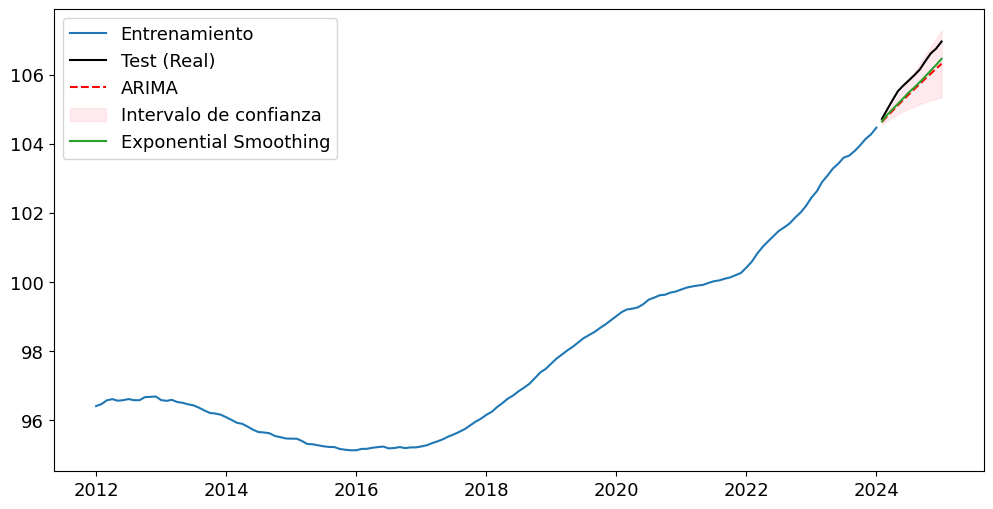

In [ ]:
plt.figure(figsize=(12,6))

# Datos de entrenamiento
plt.plot(train.index, train, label='Entrenamiento')

# Datos reales de test
plt.plot(test.index, test, label='Test (Real)', color='black')
plt.plot(forecast.index, forecast, label='ARIMA', color='red', linestyle='--')
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Intervalo de confianza')
plt.plot(fcastExpSmoothing, label='Exponential Smoothing', color='tab:green')

plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Supongamos que ya tenemos:
# test           -> valores reales (Series)
# pred_arima     -> predicciones ARIMA para test (Series con mismos índices)
# pred_exp       -> predicciones Exponential Smoothing para test (Series con mismos índices)

# 1. Calcular MAE
mae_arima = mean_absolute_error(test, forecast)
mae_exp   = mean_absolute_error(test, fcastExpSmoothing)

# 2. Calcular MSE
mse_arima = mean_squared_error(test,forecast)
mse_exp   = mean_squared_error(test, fcastExpSmoothing)

# 3. Calcular RMSE
rmse_arima = np.sqrt(mse_arima)
rmse_exp   = np.sqrt(mse_exp)

# Mostrar resultados
df_results = pd.DataFrame({
    'Modelo': ['ARIMA', 'Exponential Smoothing'],
    'MAE': [mae_arima, mae_exp],
    'MSE': [mse_arima, mse_exp],
    'RMSE': [rmse_arima, rmse_exp]
})
print(df_results)


                  Modelo       MAE       MSE      RMSE
0                  ARIMA  0.411798  0.193471  0.439854
1  Exponential Smoothing  0.349339  0.137883  0.371326


A partir de los valores numéricos de las métricas de error se puede concluir que el método de Exponential Smoothing presenta un error más bajo que ARIMA para todas las métricas consideradas (MAE, MSE, RMSE). Esto indica que, en el período de test utilizado, Exponential Smoothing logra un mejor ajuste a los valores reales y, por tanto, se desempeña mejor que ARIMA.